## 1. CONFIGURATION & IMPORTS

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


# Configuration display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 150)


# Styles graphiques
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


print("=" * 80)
print("\U0001f3c6 PREMIER LEAGUE PLAYER PERFORMANCE DATA PREPARATION")
print("=" * 80)
print(f"\ud83d\uddd3 Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 246-247: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/zmq/eventloop/zmqstream.py", line 551, in _run_callback
    f = callback(*args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 120, in _handle_event
    event_f()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to

## 2. PATH CONFIGURATION

In [133]:
import zipfile
import os
from pathlib import Path

# Check if the zip file exists and unzip it if the directory doesn't exist
zip_path = Path('/content/player_performance.zip')
expected_dir = Path('/content/player_performance')

if zip_path.exists() and not expected_dir.exists():
    print(f"📦 Unzipping {zip_path.name} to {expected_dir}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(expected_dir.parent) # extracts to /content/
    print("✅ Unzipping complete.")
elif expected_dir.exists():
    print(f"📁 Directory {expected_dir} already exists. Skipping unzipping.")
else:
    print(f"⚠️ {zip_path.name} not found. Ensure it's uploaded if needed.")


# Candidate paths: local or relative to Colab's mounted drive
candidate_paths = [
    Path('data/player_performance'),
    Path('../data/player_performance'),
    Path('../../data/player_performance'),
    Path('/content/player_performance'),
    Path("data/player_performance"),
    Path("raw/player_performance"),
    Path("raw/uncombined/player_performance"),
    Path('/content/drive/MyDrive/pl-standings-prediction-project/data/player_performance')
]

# Try to find the valid path
data_path = next((p for p in candidate_paths if p.exists()), None)

if data_path is None:
    raise FileNotFoundError('❌ player_performance folder not found in expected locations.\n'
                            'Checked: ' + ', '.join(str(p) for p in candidate_paths))

print(f"✅ Found data directory at: {data_path.resolve()}")

📁 Directory /content/player_performance already exists. Skipping unzipping.
✅ Found data directory at: /content/player_performance


## 3. LOAD ALL SEASON CSV FILES

In [28]:
seasons = [
    '2016-17', '2017-18', '2018-19', '2019-20', '2020-21',
    '2021-22', '2022-23', '2023-24', '2024-25', '2025-26'
]


all_seasons_data = []
loading_summary = []


for season in seasons:
    file_path = data_path / season / 'cleaned_players.csv'
    try:
        # Attempt to read with 'utf-8', then 'latin-1' if utf-8 fails
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding='latin-1')

        df['season'] = season
        all_seasons_data.append(df)
        loading_summary.append({'season': season, 'players': len(df), 'status': '✅ Success'})
        print(f"✅ {season}: {len(df):>4} players loaded")
    except FileNotFoundError:
        loading_summary.append({'season': season, 'players': 0, 'status': '❌ File not found'})
        print(f"❌ {season}: File not found")
    except Exception as e:
        loading_summary.append({'season': season, 'players': 0, 'status': f'❌ Error: {str(e)}'})
        print(f"❌ {season}: Error - {e}")


if all_seasons_data:
    df_combined = pd.concat(all_seasons_data, ignore_index=True)
    print(f"\n🎯 TOTAL COMBINED ROWS: {len(df_combined):,}")
else:
    raise ValueError("❌ No data loaded")


summary_df = pd.DataFrame(loading_summary)
print("\n📊 LOAD SUMMARY:")
print(summary_df.to_string(index=False))

✅ 2016-17:  683 players loaded
✅ 2017-18:  647 players loaded
✅ 2018-19:  624 players loaded
✅ 2019-20:  666 players loaded
✅ 2020-21:  713 players loaded
✅ 2021-22:  737 players loaded
✅ 2022-23:  778 players loaded
✅ 2023-24:  865 players loaded
✅ 2024-25:  804 players loaded
✅ 2025-26:  746 players loaded

🎯 TOTAL COMBINED ROWS: 7,263

📊 LOAD SUMMARY:
 season  players    status
2016-17      683 ✅ Success
2017-18      647 ✅ Success
2018-19      624 ✅ Success
2019-20      666 ✅ Success
2020-21      713 ✅ Success
2021-22      737 ✅ Success
2022-23      778 ✅ Success
2023-24      865 ✅ Success
2024-25      804 ✅ Success
2025-26      746 ✅ Success


## 4. INITIAL DATA INSPECTION



In [41]:
print("\n" + "=" * 80)
print("🔍 STEP 4: INITIAL DATA INSPECTION")
print("=" * 80)

print(f"\n📊 Data shape: {df_combined.shape}")
print(f"   • Rows   : {df_combined.shape[0]:,}")
print(f"   • Columns: {df_combined.shape[1]}")

print(f"\n📅 Seasons covered: {df_combined['season'].nunique()}")
print(f"   {sorted(df_combined['season'].unique())}")

# Detect available name columns
name_cols = [col for col in df_combined.columns if 'name' in col.lower()]

print("\n👥 Player name columns detected:", name_cols)

# Display unique players based on best available name column
if 'player_name' in df_combined.columns:
    print(f"👥 Unique players (player_name): {df_combined['player_name'].nunique():,}")
elif 'second_name' in df_combined.columns:
    print(f"👥 Unique players (second_name): {df_combined['second_name'].nunique():,}")
elif 'first_name' in df_combined.columns:
    print(f"👥 Unique players (first_name): {df_combined['first_name'].nunique():,}")
else:
    print("⚠️ No player name column found for uniqueness count.")

print("\n📋 Available columns:")
for i, col in enumerate(df_combined.columns, 1):
    print(f"   {i:2d}. {col}")

print("\n🔎 Sample preview (first 3 rows):")
print(df_combined.head(3))

print("\n📈 Data types overview (count by dtype):")
print(df_combined.dtypes.value_counts())



🔍 STEP 4: INITIAL DATA INSPECTION

📊 Data shape: (7263, 21)
   • Rows   : 7,263
   • Columns: 21

📅 Seasons covered: 10
   ['2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25', '2025-26']

👥 Player name columns detected: ['first_name', 'second_name']
👥 Unique players (second_name): 2,352

📋 Available columns:
    1. first_name
    2. second_name
    3. goals_scored
    4. assists
    5. total_points
    6. minutes
    7. goals_conceded
    8. creativity
    9. influence
   10. threat
   11. bonus
   12. bps
   13. ict_index
   14. clean_sheets
   15. red_cards
   16. yellow_cards
   17. selected_by_percent
   18. season
   19. now_cost
   20. element_type
   21. value_per_m

🔎 Sample preview (first 3 rows):
  first_name second_name  goals_scored  assists  total_points  minutes  goals_conceded  creativity  influence  threat  bonus  bps  ict_index  \
0      David      Ospina             0        0             2      143               4      

## 5. MISSING VALUE ANALYSIS




🔍 STEP 5: MISSING VALUE ANALYSIS

⚠️ Columns with missing values detected:
      column  missing_count  missing_percent
 value_per_m           6517            89.73
element_type           2620            36.07
    now_cost            683             9.40


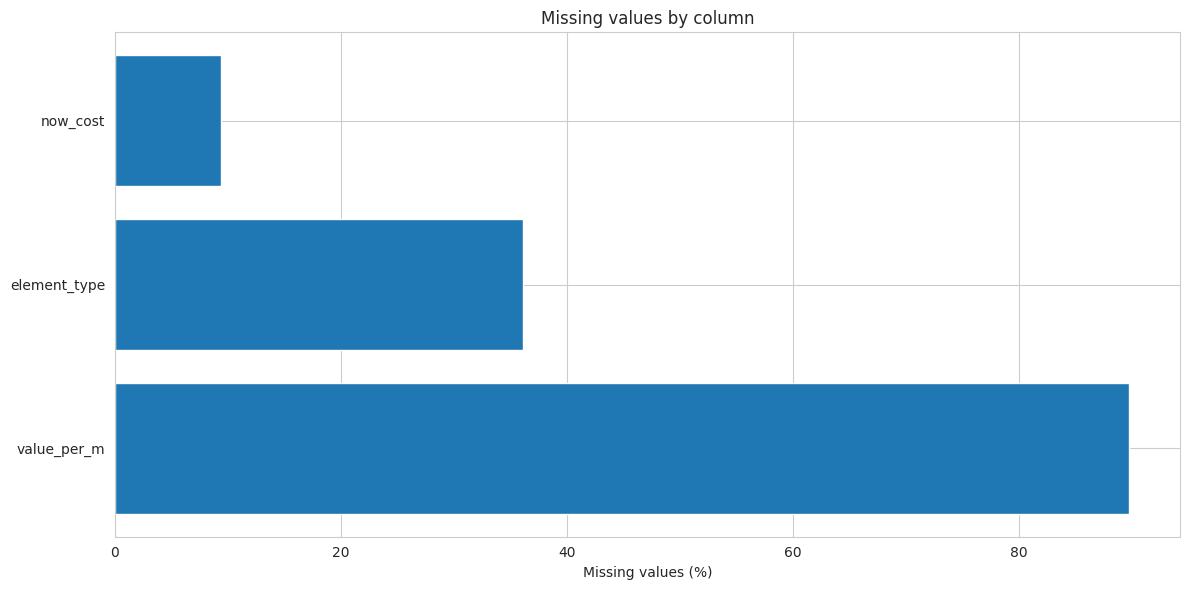

In [42]:
print("\n" + "=" * 80)
print("🔍 STEP 5: MISSING VALUE ANALYSIS")
print("=" * 80)

# Prevent division by zero in case dataframe is empty
if len(df_combined) == 0:
    print("⚠️ Dataset is empty. Missing value analysis skipped.")
else:
    # Build missing values table
    missing_analysis = pd.DataFrame({
        'column': df_combined.columns,
        'missing_count': df_combined.isnull().sum(),
        'missing_percent': (df_combined.isnull().sum() / len(df_combined) * 100).round(2)
    })

    # Keep only columns with missing values
    missing_analysis = (
        missing_analysis[missing_analysis['missing_count'] > 0]
        .sort_values('missing_percent', ascending=False)
    )

    if len(missing_analysis) > 0:
        print("\n⚠️ Columns with missing values detected:")
        print(missing_analysis.to_string(index=False))

        # Visualization: Missing percentage bar chart
        plt.figure(figsize=(12, 6))
        plt.barh(missing_analysis['column'], missing_analysis['missing_percent'])
        plt.xlabel('Missing values (%)')
        plt.title('Missing values by column')
        plt.tight_layout()
        plt.show()
    else:
        print("\n✅ No missing values detected in the dataset!")


## 6. COLUMN SELECTION (PLAYER PERFORMANCE FOCUS)



In [112]:
print("\n" + "=" * 80)
print("🎯 STEP 6: SELECT RELEVANT COLUMNS FOR PLAYER PERFORMANCE")
print("=" * 80)

# -----------------------------
# Define the columns you want
# -----------------------------
selected_columns = {
    "identity": ["first_name", "second_name"],
    "context": ["season"],   #
    "value": ["now_cost", "selected_by_percent"],
    "performance": ["total_points", "points_per_game", "form", "minutes"],
    "offensive": ["goals_scored", "assists", "creativity", "threat"],
    "defensive": ["clean_sheets", "goals_conceded", "yellow_cards", "red_cards"],
    "advanced": ["influence", "ict_index", "bonus", "bps"]
}

# -----------------------------
# Flatten the full list
# -----------------------------
all_selected = []
for cols in selected_columns.values():
    all_selected.extend(cols)

# -----------------------------
# Keep only columns that exist
# -----------------------------
available_columns = [c for c in all_selected if c in df_combined.columns]
missing_columns = [c for c in all_selected if c not in df_combined.columns]

print(f"\n✅ Selected columns found: {len(available_columns)}/{len(all_selected)}")

if missing_columns:
    print("\n⚠️ Missing columns (ignored):")
    for col in missing_columns:
        print(f"   • {col}")

# -----------------------------
# Create df_selected
# -----------------------------
df_selected = df_combined[available_columns].copy()

print(f"\n📊 Shape after selection: {df_selected.shape}")



🎯 STEP 6: SELECT RELEVANT COLUMNS FOR PLAYER PERFORMANCE

✅ Selected columns found: 19/21

⚠️ Missing columns (ignored):
   • points_per_game
   • form

📊 Shape after selection: (7263, 19)


## 7. DATA CLEANING & FILTERING



In [113]:
print("\n" + "=" * 80)
print("🧹 STEP 7: DATA CLEANING & FILTERING")
print("=" * 80)

initial_rows = len(df_selected)

# ============================================================
# 7.1 HANDLE MISSING VALUES
# ============================================================
print("\n📝 Handling missing values...")

# Numeric columns → fill NaN with 0
numeric_cols = df_selected.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    if df_selected[col].isnull().sum() > 0:
        df_selected[col] = df_selected[col].fillna(0)
        print(f"   • {col}: filled NaN with 0")

# Text columns → fill NaN with "Unknown"
text_cols = df_selected.select_dtypes(include=['object']).columns
for col in text_cols:
    if df_selected[col].isnull().sum() > 0:
        df_selected[col] = df_selected[col].fillna("Unknown")
        print(f"   • {col}: filled NaN with 'Unknown'")


# ============================================================
# 7.1.1 DROP USELESS COLUMNS
# ============================================================
print("\n🗑️ Dropping useless columns...")

missing_threshold = 0.90
cols_to_drop = []

for col in df_selected.columns:
    # NEVER drop these essential columns
    if col in ['first_name', 'second_name', 'season', 'minutes', 'total_points']:
        continue

    miss = df_selected[col].isnull().mean()
    uniq = df_selected[col].nunique(dropna=True)

    if miss > missing_threshold or uniq <= 1:
        cols_to_drop.append(col)

if cols_to_drop:
    df_selected.drop(columns=cols_to_drop, inplace=True)
    print(f"   • Dropped: {cols_to_drop}")
else:
    print("   • No columns dropped")


# ============================================================
# 7.2 FILTER BY MINUTES PLAYED
# ============================================================
print("\n⏱️ Filtering players by minutes ≥ 90...")

min_minutes = 90
df_filtered = df_selected[df_selected['minutes'] >= min_minutes].copy()

filtered_out = initial_rows - len(df_filtered)

print(f"   • Players kept       : {len(df_filtered)}")
print(f"   • Players filtered   : {filtered_out} ({filtered_out/initial_rows*100:.1f}%)")


# ============================================================
# 7.3 REMOVE DUPLICATES (by first + second name + season)
# ============================================================
print("\n🔄 Removing duplicates...")

df_filtered['_temp_player_name'] = (
    df_filtered['first_name'].astype(str) + " " + df_filtered['second_name'].astype(str)
).str.strip()

dups = df_filtered.duplicated(subset=['_temp_player_name', 'season']).sum()

if dups > 0:
    print(f"   • Removed {dups} duplicate rows")
    df_filtered = df_filtered.drop_duplicates(subset=['_temp_player_name', 'season'])
else:
    print("   • No duplicates found")

df_filtered.drop(columns=['_temp_player_name'], inplace=True)

print(f"\n✅ Final shape after cleaning: {df_filtered.shape}")

# ============================================================
# No POSITION column created (because no element_type)
# ============================================================

print("\nℹ️ No 'position' column generated (no element_type in dataset).")



🧹 STEP 7: DATA CLEANING & FILTERING

📝 Handling missing values...
   • now_cost: filled NaN with 0

🗑️ Dropping useless columns...
   • No columns dropped

⏱️ Filtering players by minutes ≥ 90...
   • Players kept       : 4659
   • Players filtered   : 2604 (35.9%)

🔄 Removing duplicates...
   • No duplicates found

✅ Final shape after cleaning: (4659, 19)

ℹ️ No 'position' column generated (no element_type in dataset).


##8. DERIVED FEATURE CREATION (PLAYER PERFORMANCE)



In [114]:
print("\n" + "=" * 80)
print("⚙️ STEP 8: DERIVED FEATURE CREATION")
print("=" * 80)

df_enriched = df_filtered.copy()

# ============================================================
# Avoid division by zero
# ============================================================
if 'minutes' in df_enriched.columns:
    matches = (df_enriched['minutes'] / 90).replace(0, np.nan)
else:
    print("⚠️ 'minutes' column missing — cannot compute per-90 metrics.")
    matches = None


# ============================================================
# Offensive metrics
# ============================================================
if matches is not None and 'goals_scored' in df_enriched.columns:
    df_enriched['goals_per_90'] = (df_enriched['goals_scored'] / matches).round(3)
    print("   • goals_per_90 created")

if matches is not None and 'assists' in df_enriched.columns:
    df_enriched['assists_per_90'] = (df_enriched['assists'] / matches).round(3)
    print("   • assists_per_90 created")


# ============================================================
# Goal involvement
# ============================================================
if all(col in df_enriched.columns for col in ['goals_scored', 'assists']):
    df_enriched['goal_involvement'] = (
        df_enriched['goals_scored'] + df_enriched['assists']
    )
    df_enriched['goal_involvement_per_90'] = (
        df_enriched['goal_involvement'] / matches
    ).round(3)
    print("   • goal_involvement & goal_involvement_per_90 created")


# ============================================================
# Defensive metrics
# ============================================================
if matches is not None and 'clean_sheets' in df_enriched.columns:
    df_enriched['clean_sheet_rate'] = (df_enriched['clean_sheets'] / matches).round(3)
    print("   • clean_sheet_rate created")


# ============================================================
# Discipline metrics
# ============================================================
if all(col in df_enriched.columns for col in ['yellow_cards', 'red_cards']):
    df_enriched['total_cards'] = (
        df_enriched['yellow_cards'] + df_enriched['red_cards'] * 2
    )
    df_enriched['cards_per_90'] = (
        df_enriched['total_cards'] / matches
    ).round(3)
    print("   • total_cards & cards_per_90 created")


# ============================================================
# Efficiency: points_per_cost
# ============================================================
if all(col in df_enriched.columns for col in ['total_points', 'now_cost']):
    df_enriched['points_per_cost'] = (
        df_enriched['total_points'] / df_enriched['now_cost']
    ).replace([np.inf, -np.inf], 0).round(3)
    print("   • points_per_cost created")


# ============================================================
# Ranking per season
# ============================================================
if all(col in df_enriched.columns for col in ['total_points', 'season']):
    df_enriched['rank_in_season'] = (
        df_enriched.groupby('season')['total_points']
        .rank(method='min', ascending=False)
        .astype(int)
    )
    print("   • rank_in_season created")


# ============================================================
# Final output
# ============================================================
print(f"\n📊 Final shape after feature engineering: {df_enriched.shape}")



⚙️ STEP 8: DERIVED FEATURE CREATION
   • goals_per_90 created
   • assists_per_90 created
   • goal_involvement & goal_involvement_per_90 created
   • clean_sheet_rate created
   • total_cards & cards_per_90 created
   • points_per_cost created
   • rank_in_season created

📊 Final shape after feature engineering: (4659, 28)


##9. ENCODING CATEGORICAL VARIABLES



In [115]:
print("\n" + "=" * 80)
print("🔤 STEP 9: ENCODING CATEGORICAL VARIABLES")
print("=" * 80)

df_encoded = df_enriched.copy()

# ============================================================
# 1. Encode categorical columns (only those that exist)
# ============================================================
categorical_cols = ['season']   # no 'position' in your dataset

for col in categorical_cols:
    if col in df_encoded.columns:
        df_encoded[col] = df_encoded[col].astype('category')
        df_encoded[f"{col}_encoded"] = df_encoded[col].cat.codes
        print(f"   • Encoded '{col}' → '{col}_encoded'")
    else:
        print(f"   • Skipped '{col}' (column not found)")


# ============================================================
# 2. Create unified player_name field
# ============================================================
has_first = 'first_name' in df_encoded.columns
has_second = 'second_name' in df_encoded.columns

if has_first and has_second:
    df_encoded['player_name'] = (
        df_encoded['first_name'].astype(str) + " " + df_encoded['second_name'].astype(str)
    ).str.strip()
elif has_second:
    df_encoded['player_name'] = df_encoded['second_name'].astype(str)
elif has_first:
    df_encoded['player_name'] = df_encoded['first_name'].astype(str)
else:
    df_encoded['player_name'] = "Unknown Player"

df_encoded['player_name'] = df_encoded['player_name'].replace('', 'Unknown Player')

print("   • 'player_name' column created.")


# ============================================================
# Summary
# ============================================================
print("\n✅ Encoding complete.")
print("📊 Shape:", df_encoded.shape)



🔤 STEP 9: ENCODING CATEGORICAL VARIABLES
   • Encoded 'season' → 'season_encoded'
   • 'player_name' column created.

✅ Encoding complete.
📊 Shape: (4659, 30)


##10. DESCRIPTIVE STATISTICS



In [118]:
print("\n" + "=" * 80)
print("📈 STEP 10: DESCRIPTIVE STATISTICS")
print("=" * 80)

# ---------------------------------------------------------
# NUMERIC METRICS SUMMARY
# ---------------------------------------------------------
metrics = ['total_points', 'goals_scored', 'assists', 'clean_sheets', 'minutes']
available = [m for m in metrics if m in df_encoded.columns]

if available:
    print("\n📊 Key metrics:")
    print(df_encoded[available].describe().round(2))
else:
    print("\n⚠️ No performance metrics found.")

# ---------------------------------------------------------
# SEASON DISTRIBUTION
# ---------------------------------------------------------
if 'season' in df_encoded.columns:
    print("\n📅 Season distribution:")
    print(df_encoded['season'].value_counts().sort_index())
else:
    print("\n⚠️ 'season' column missing.")





📈 STEP 10: DESCRIPTIVE STATISTICS

📊 Key metrics:
       total_points  goals_scored  assists  clean_sheets  minutes
count       4659.00       4659.00  4659.00       4659.00  4659.00
mean          61.93          2.06     1.86          4.60  1481.98
std           47.28          3.58     2.66          4.08   983.91
min           -3.00          0.00     0.00          0.00    90.00
25%           24.00          0.00     0.00          1.00   600.00
50%           51.00          1.00     1.00          4.00  1360.00
75%           91.00          2.00     3.00          7.00  2289.00
max          344.00         36.00    23.00         21.00  3420.00

📅 Season distribution:
season
2016-17    478
2017-18    471
2018-19    456
2019-20    466
2020-21    470
2021-22    480
2022-23    483
2023-24    487
2024-25    497
2025-26    371
Name: count, dtype: int64


## 11. EXPLORATORY VISUALISATIONS




📊 STEP 11: EXPLORATORY VISUALISATIONS


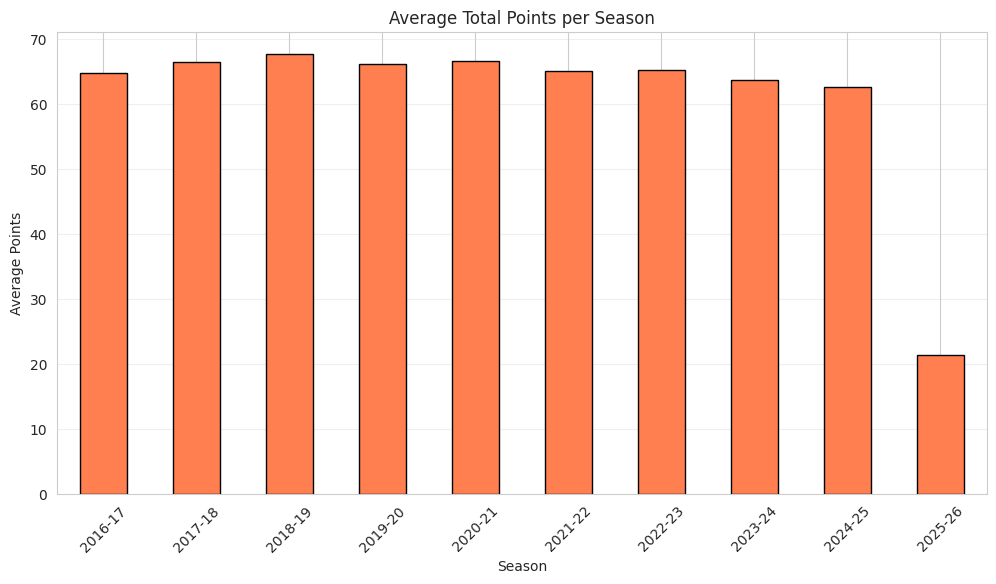

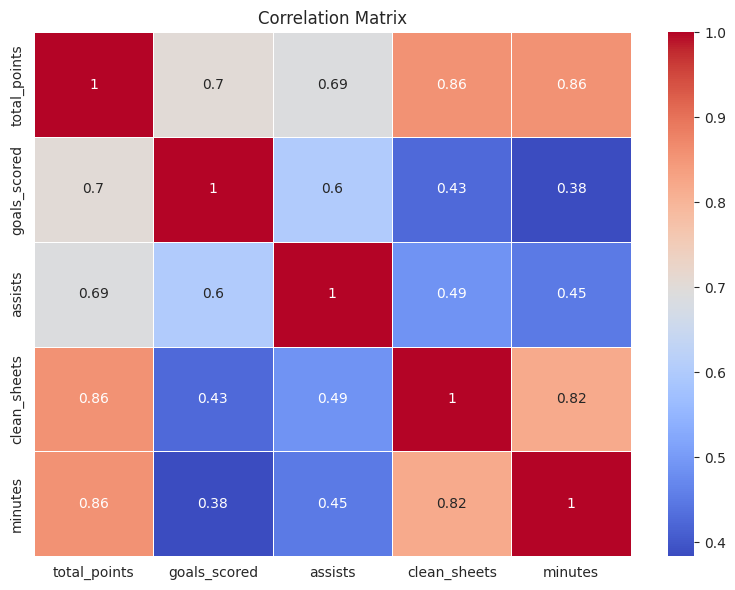

In [121]:
print("\n" + "=" * 80)
print("📊 STEP 11: EXPLORATORY VISUALISATIONS")
print("=" * 80)




# ============================================================
# 11.1 Average Total Points Per Season
# ============================================================

if 'season' in df_encoded.columns and 'total_points' in df_encoded.columns:
    avg = df_encoded.groupby('season')['total_points'].mean()

    plt.figure(figsize=(12,6))
    avg.plot(kind='bar', color='coral', edgecolor='black')
    plt.title("Average Total Points per Season")
    plt.xlabel("Season")
    plt.ylabel("Average Points")
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.show()
else:
    print("\n⚠️ Missing 'season' or 'total_points' → cannot compute seasonal averages.")


# ============================================================
# 11.2 Correlation Matrix
# ============================================================

corr_features = ['total_points','goals_scored','assists','clean_sheets','minutes']
corr_available = [c for c in corr_features if c in df_encoded.columns]

if len(corr_available) >= 2:
    plt.figure(figsize=(8,6))
    sns.heatmap(df_encoded[corr_available].corr(),
                annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title("Correlation Matrix")
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Not enough numeric features for correlation matrix.")


## 12. IDENTIFYING TOP PERFORMERS



In [122]:
print("\n" + "=" * 80)
print("🏆 STEP 12: IDENTIFYING TOP PERFORMERS")
print("=" * 80)

# ============================================================
# 1. CREATE PLAYER NAME COLUMN (first + second name)
# ============================================================

first = 'first_name' in df_encoded.columns
second = 'second_name' in df_encoded.columns

if first and second:
    df_encoded['player_name'] = (
        df_encoded['first_name'].astype(str) + " " +
        df_encoded['second_name'].astype(str)
    ).str.strip()
elif second:
    df_encoded['player_name'] = df_encoded['second_name'].astype(str)
elif first:
    df_encoded['player_name'] = df_encoded['first_name'].astype(str)
else:
    df_encoded['player_name'] = "Unknown Player"

df_encoded['player_name'] = df_encoded['player_name'].replace("", "Unknown Player")

print("🎯 Player name column created.")


# ============================================================
# 2. TOP 50 PER SEASON
# ============================================================

top_performers_list = []

if 'season' in df_encoded.columns and 'total_points' in df_encoded.columns:

    for season in sorted(df_encoded['season'].unique()):
        season_data = df_encoded[df_encoded['season'] == season]
        top_50 = season_data.nlargest(50, 'total_points')
        top_performers_list.append(top_50)

    df_top_performers = pd.concat(top_performers_list, ignore_index=True)

    print(f"\n✅ Top 50 players extracted for each season.")
    print(f"📊 Total records in top_performers dataset: {len(df_top_performers):,}")

    # Preview for user
    print("\n👀 SAMPLE: Top 5 per season (player_name + points):")
    for season in sorted(df_top_performers['season'].unique()):
        season_top_5 = (
            df_top_performers[df_top_performers['season'] == season]
            .nlargest(5, 'total_points')
        )

        preview_cols = ['player_name', 'season', 'total_points', 'goals_scored', 'assists']
        preview_cols = [c for c in preview_cols if c in season_top_5.columns]

        print(f"\n— Season {season} —")
        print(season_top_5[preview_cols].to_string(index=False))

else:
    print("⚠️ Missing 'season' or 'total_points' — cannot compute top performers.")
    df_top_performers = pd.DataFrame()


# ============================================================
# 3. GLOBAL TOP 10
# ============================================================

if 'total_points' in df_encoded.columns and not df_encoded.empty:

    print("\n🥇 GLOBAL TOP 10 PLAYERS (by total_points):")

    # Only columns that actually exist
    columns_to_display = [
        'player_name', 'season',
        'total_points', 'goals_scored', 'assists', 'minutes'
    ]
    columns_to_display = [c for c in columns_to_display if c in df_encoded.columns]

    top_10_global = df_encoded.nlargest(10, 'total_points')[columns_to_display]

    print(top_10_global.to_string(index=False))

else:
    print("⚠️ Cannot compute global top 10 — missing 'total_points'.")



🏆 STEP 12: IDENTIFYING TOP PERFORMERS
🎯 Player name column created.

✅ Top 50 players extracted for each season.
📊 Total records in top_performers dataset: 500

👀 SAMPLE: Top 5 per season (player_name + points):

— Season 2016-17 —
   player_name  season  total_points  goals_scored  assists
Alexis Sánchez 2016-17           264            24       11
 Bamidele Alli 2016-17           225            18       11
   Eden Hazard 2016-17           224            16        9
    Harry Kane 2016-17           224            29        7
 Romelu Lukaku 2016-17           221            25        6

— Season 2017-18 —
      player_name  season  total_points  goals_scored  assists
    Mohamed Salah 2017-18           303            32       12
  Raheem Sterling 2017-18           229            18       17
       Harry Kane 2017-18           217            29        2
  Kevin De Bruyne 2017-18           209             8       18
Christian Eriksen 2017-18           199            11       10

— Season

In [125]:
print("\n" + "=" * 80)
print("📁 DATASET AFTER FULL CLEANING & PROCESSING")
print("=" * 80)

print(df_encoded.head(20))
print("\nShape:", df_encoded.shape)



📁 DATASET AFTER FULL CLEANING & PROCESSING
         first_name         second_name   season  now_cost  selected_by_percent  total_points  minutes  goals_scored  assists  creativity  threat  \
0             David              Ospina  2016-17       0.0                  0.2             2      143             0        0         0.0     0.0   
1              Petr                Cech  2016-17       0.0                 13.7           134     3097             0        0         0.1     0.0   
2           Laurent           Koscielny  2016-17       0.0                 11.2           121     2821             2        1        53.9   239.0   
4   Gabriel Armando            de Abreu  2016-17       0.0                  0.8            45     1517             0        0        84.5   119.0   
5            Héctor            Bellerín  2016-17       0.0                 13.9           119     2503             1        5       508.3   395.0   
6            Kieran               Gibbs  2016-17       0.0    

## 13. PRINCIPAL COMPONENT ANALYSIS (PCA) FOR PLAYER PERFORMANCE DATA




🔬 STEP 12.5: PRINCIPAL COMPONENT ANALYSIS (PCA)
📊 Numeric features available for PCA: 25

📈 Variance explained by first components:
   PC1: 48.22%
   PC2: 14.88%
   PC3: 8.05%
   PC4: 4.68%
   PC5: 4.48%


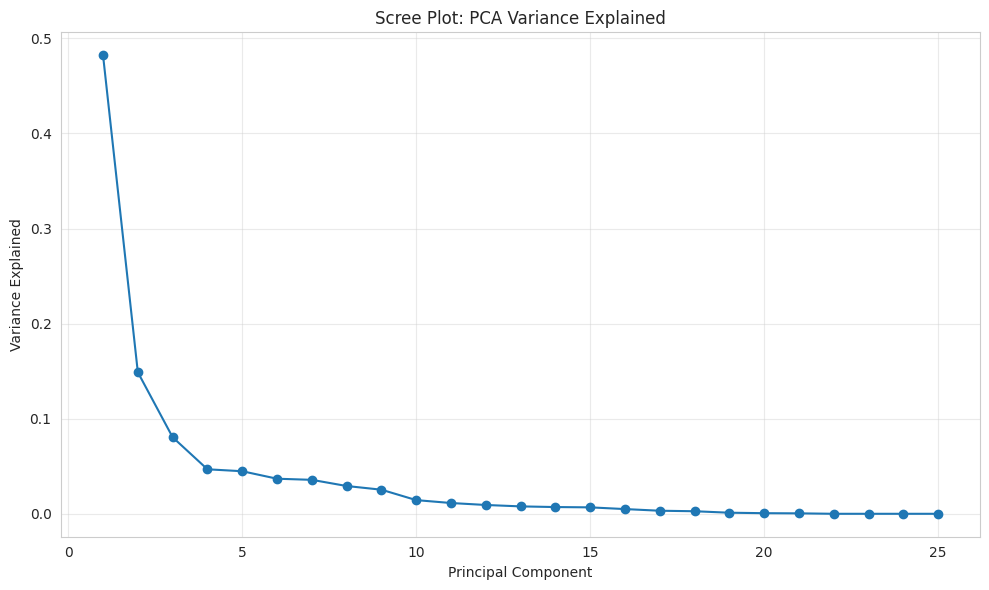

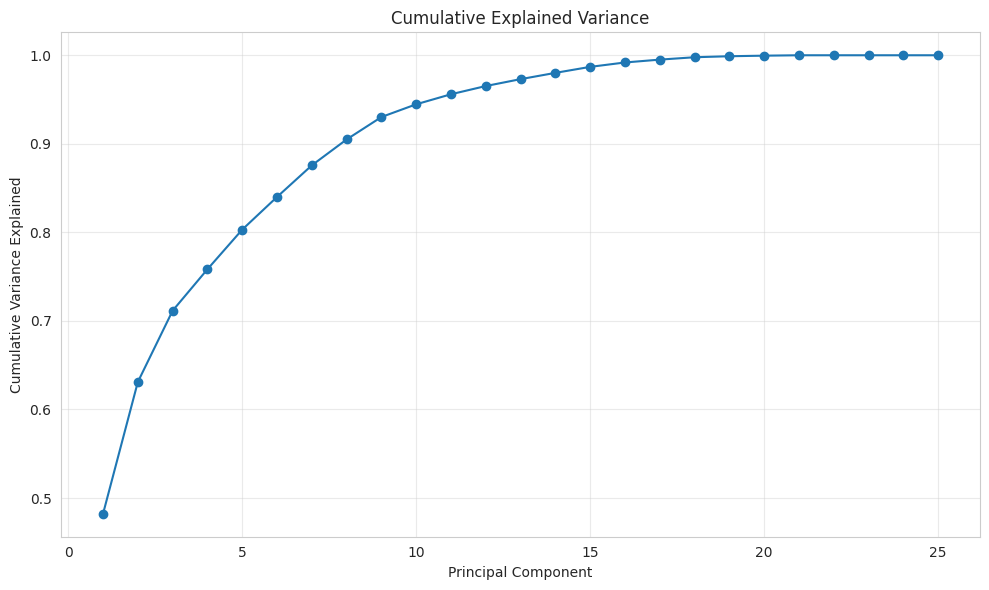


📊 PCA projection dataframe sample:
        PC1       PC2               player_name   season
0 -4.815563  0.557766              David Ospina  2016-17
1  1.248444 -2.897296                 Petr Cech  2016-17
2  2.849106 -3.037831         Laurent Koscielny  2016-17
4 -1.679085 -2.211630  Gabriel Armando de Abreu  2016-17
5  2.915851 -1.020428           Héctor Bellerín  2016-17


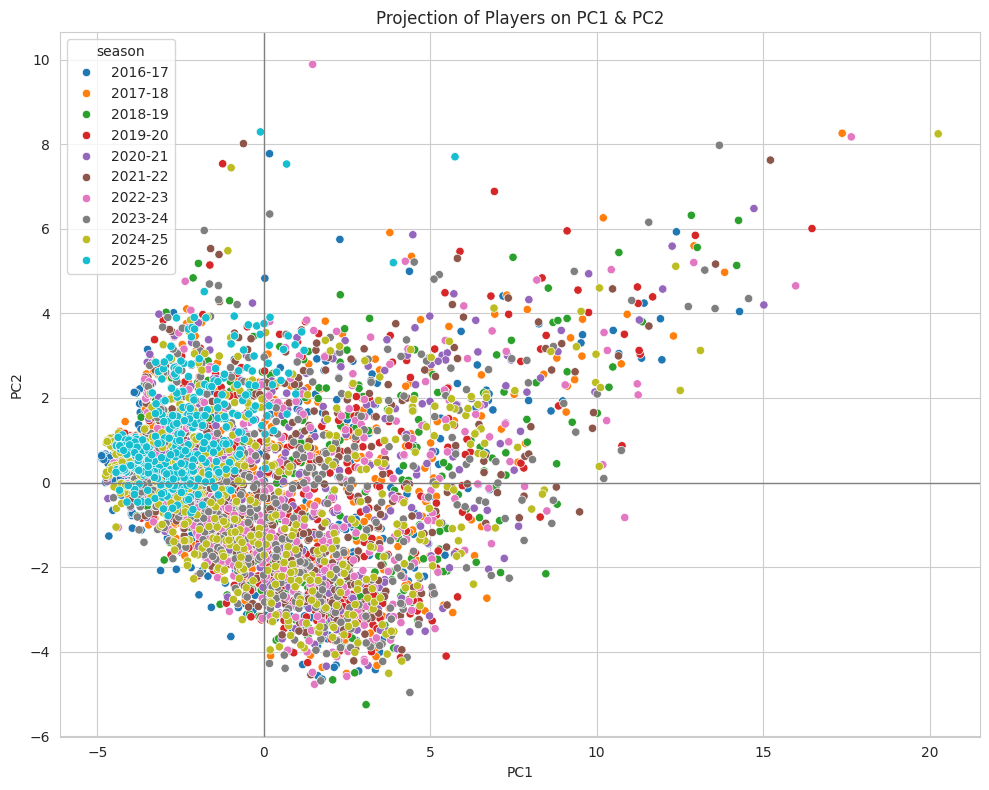

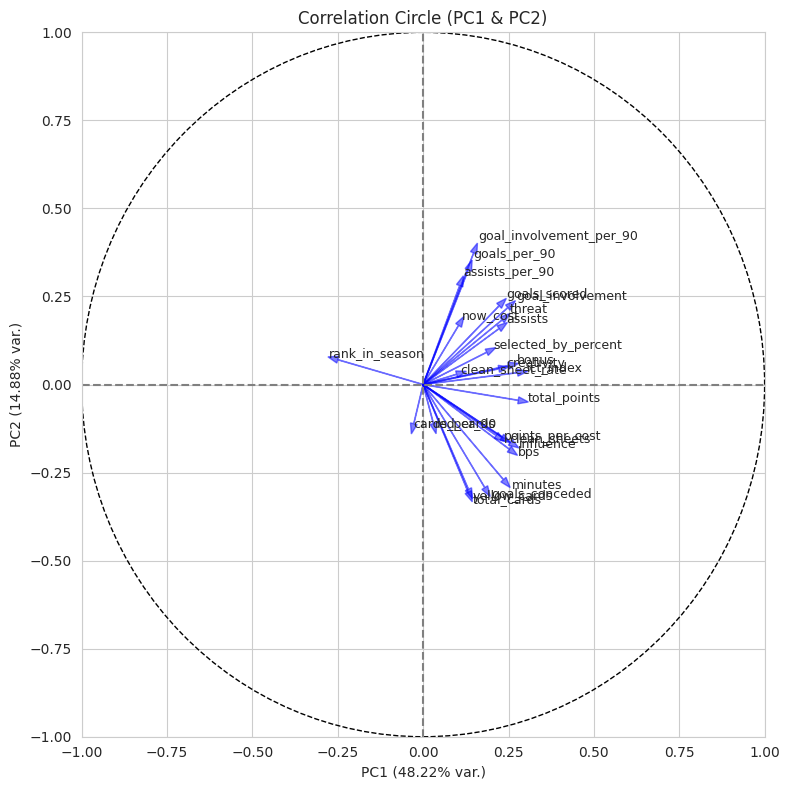

In [124]:
print("\n" + "=" * 80)
print("🔬 STEP 12.5: PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("=" * 80)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ----------------------------------------------------------
# 1. Select numerical features for PCA
# ----------------------------------------------------------
# Exclude encoded categorical variables (if they exist)
exclude_cols = ['season_encoded', 'team_encoded', 'position_encoded']

numeric_df = df_encoded.select_dtypes(include=[np.number]).copy()
numeric_df = numeric_df[[c for c in numeric_df.columns if c not in exclude_cols]]

print(f"📊 Numeric features available for PCA: {numeric_df.shape[1]}")

# Drop rows with NaN values for PCA stability
numeric_df_clean = numeric_df.dropna()

if numeric_df_clean.shape[0] < 2:
    print("\n⚠️ Not enough valid rows for PCA. Skipping PCA step.")
else:
    # ------------------------------------------------------
    # 2. Standardization
    # ------------------------------------------------------
    scaler = StandardScaler()
    numeric_scaled = scaler.fit_transform(numeric_df_clean)

    # ------------------------------------------------------
    # 3. PCA computation
    # ------------------------------------------------------
    pca = PCA()
    pca_components = pca.fit_transform(numeric_scaled)
    explained_var = pca.explained_variance_ratio_

    print("\n📈 Variance explained by first components:")
    for i, var in enumerate(explained_var[:5]):
        print(f"   PC{i+1}: {var*100:.2f}%")

    # ------------------------------------------------------
    # 4. Scree plot
    # ------------------------------------------------------
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained")
    plt.title("Scree Plot: PCA Variance Explained")
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------
    # 5. Cumulative explained variance
    # ------------------------------------------------------
    cumulative_var = explained_var.cumsum()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_var)+1), cumulative_var, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained")
    plt.title("Cumulative Explained Variance")
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------
    # 6. PCA projection dataframe (PC1 & PC2)
    # ------------------------------------------------------
    pca_df = pd.DataFrame({
        "PC1": pca_components[:, 0],
        "PC2": pca_components[:, 1]
    }, index=numeric_df_clean.index)

    if 'player_name' in df_encoded.columns:
        pca_df['player_name'] = df_encoded.loc[pca_df.index, 'player_name']

    if 'season' in df_encoded.columns:
        pca_df['season'] = df_encoded.loc[pca_df.index, 'season']

    print("\n📊 PCA projection dataframe sample:")
    print(pca_df.head())

    # ------------------------------------------------------
    # 7. Scatter plot PC1 vs PC2 (colored by season if available)
    # ------------------------------------------------------
    plt.figure(figsize=(10, 8))
    if 'season' in pca_df.columns:
        sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="season", palette="tab10")
    else:
        sns.scatterplot(data=pca_df, x="PC1", y="PC2")
    plt.title("Projection of Players on PC1 & PC2")
    plt.axhline(0, color='grey', linewidth=1)
    plt.axvline(0, color='grey', linewidth=1)
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------
    # 8. Correlation Circle (Cercle de corrélation)
    #     (variables contributions on PC1 & PC2)
    # ------------------------------------------------------
    variables = numeric_df_clean.columns           # names of original numeric variables
    pcs = pca.components_                          # eigenvectors matrix
    x_vector = pcs[0, :]                           # loadings on PC1
    y_vector = pcs[1, :]                           # loadings on PC2

    plt.figure(figsize=(8, 8))
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(0, color='grey', linestyle='--')

    for i in range(len(variables)):
        plt.arrow(0, 0,
                  x_vector[i], y_vector[i],
                  color='blue', alpha=0.5, head_width=0.02)
        plt.text(x_vector[i]*1.1,
                 y_vector[i]*1.1,
                 variables[i],
                 fontsize=9)

    # unit circle
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
    plt.gca().add_artist(circle)

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.grid(True)
    plt.title("Correlation Circle (PC1 & PC2)")
    plt.xlabel(f"PC1 ({explained_var[0]*100:.2f}% var.)")
    plt.ylabel(f"PC2 ({explained_var[1]*100:.2f}% var.)")
    plt.tight_layout()
    plt.show()


## 13. SAVING PROCESSED DATASETS & METADATA



In [126]:
print("\n" + "=" * 80)
print("💾 STEP 13: SAVING PROCESSED DATASETS")
print("=" * 80)

# Create output folder
processed_path = Path(data_path) / 'processed'
processed_path.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------
# 13.1 Save FULL processed dataset
# ------------------------------------------------------
output_complete = processed_path / 'players_cleaned_complete.csv'
df_encoded.to_csv(output_complete, index=False)

print(f"\n✅ Full processed dataset saved:")
print(f"   📁 {output_complete}")
print(f"   📊 {df_encoded.shape[0]:,} rows × {df_encoded.shape[1]} columns")

# ------------------------------------------------------
# 13.2 Save Top Performers dataset
# ------------------------------------------------------
if 'df_top_performers' in locals() and not df_top_performers.empty:
    output_top = processed_path / 'players_top_performers.csv'
    df_top_performers.to_csv(output_top, index=False)

    print(f"\n✅ Top performers saved:")
    print(f"   📁 {output_top}")
    print(f"   📊 {df_top_performers.shape[0]:,} rows")
else:
    print("\n⚠️ Top performers dataset empty — nothing saved.")

# ------------------------------------------------------
# 13.3 Season-Level Statistics
# ------------------------------------------------------
if 'season' in df_encoded.columns:

    agg_dict = {'player_name': 'count'}

    for col in ['total_points', 'goals_scored', 'assists', 'minutes']:
        if col in df_encoded.columns:
            if col == 'total_points':
                agg_dict[col] = ['mean', 'median', 'std', 'max']
            else:
                agg_dict[col] = 'sum'

    season_summary = df_encoded.groupby('season').agg(agg_dict).round(2)

    # Flatten MultiIndex
    season_summary.columns = [
        '_'.join(col).strip() if isinstance(col, tuple) else col
        for col in season_summary.columns
    ]

    output_summary = processed_path / 'players_season_statistics.csv'
    season_summary.to_csv(output_summary)

    print(f"\n✅ Season statistics saved:")
    print(f"   📁 {output_summary}")

# ------------------------------------------------------
# 13.4 Save metadata (JSON)
# ------------------------------------------------------
metadata = {
    'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),

    'total_records': int(df_encoded.shape[0]),
    'total_columns': int(df_encoded.shape[1]),

    'seasons_covered': (
        sorted(df_encoded['season'].unique().tolist())
        if 'season' in df_encoded.columns else []
    ),

    'unique_players': (
        int(df_encoded['player_name'].nunique())
        if 'player_name' in df_encoded.columns else None
    ),

    'key_features': {
        'identity': [c for c in ['player_name','first_name','second_name'] if c in df_encoded.columns],
        'categorical': [c for c in ['season'] if c in df_encoded.columns],
        'encoded': [c for c in df_encoded.columns if c.endswith('_encoded')],
        'performance': [c for c in ['total_points','minutes'] if c in df_encoded.columns],
        'offensive': [c for c in ['goals_scored','assists','goal_involvement'] if c in df_encoded.columns],
        'defensive': [c for c in ['clean_sheets','goals_conceded'] if c in df_encoded.columns],
        'derived': [
            c for c in [
                'goals_per_90','assists_per_90','clean_sheet_rate',
                'rank_in_season','points_per_cost'
            ] if c in df_encoded.columns
        ]
    },

    'filtering_criteria': {
        'min_minutes': int(min_minutes),
        'players_filtered_out': int(filtered_out)
    }
}

output_metadata = processed_path / 'metadata.json'
with open(output_metadata, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n✅ Metadata saved:")
print(f"   📁 {output_metadata}")



💾 STEP 13: SAVING PROCESSED DATASETS

✅ Full processed dataset saved:
   📁 /content/player_performance/processed/players_cleaned_complete.csv
   📊 4,659 rows × 30 columns

✅ Top performers saved:
   📁 /content/player_performance/processed/players_top_performers.csv
   📊 500 rows

✅ Season statistics saved:
   📁 /content/player_performance/processed/players_season_statistics.csv

✅ Metadata saved:
   📁 /content/player_performance/processed/metadata.json


In [131]:
!git clone https://github.com/AtfastrSlushyMaker/pl-standings-prediction-project.git
!cp -r /content/player_performance/processed /content/pl-standings-prediction-project/data/


fatal: destination path 'pl-standings-prediction-project' already exists and is not an empty directory.
